# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.



# Цели проекта
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 - выделить целевые группы клиентов;
 - предложить меры по снижению оттока;
 - определить другие особенности взаимодействия с клиентами.




## Загрузка данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. **Набор данных включает следующие поля:**

- 'Churn' — факт оттока в текущем месяце

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [32]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.shape

(4000, 14)

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков у нас нет - 4000 значений в каждом из 14 столбцов.

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Итак, как мы видим:
- "gender" - по возрасту клиенты сети фитнес-центров «Культурист-датасаентист» разделились примерно поровну (среднее значение 0.51 при возможных значениях только 0 и 1 говорит нам об этом).
- "Near_Location" - больше 84% клиентов скорее всего выбрали нашу сеть из-за близости к работе/дому (Я их понимаю, сам так же выбирал).
- "Partner" - около 49% клиентов пришли к нам с партнерскими скидками, видимо, это те, кому фитнес-зал ближе к работе.
- "Promo_friends" - около 31% клиентов пришли вслед за друзьями. Интересно, сеть так хороша, или фитнесом водиночку заниматься, всё же, трудно.
- "Phone" - 90% оставили свой номер телефона. Исходя из своего жизненного опыта, мне интересно, как остальные 10% хитрецов умудрились отговориться от того, чтобы не заполнять эту графу в договоре.
- "Contract_period" - из этой графы мы можем понять, что сеть продаёт абонименты сроком от 1, до 12 месяцев, однако больше половины клиентов берут всего 1 месяц.
- "Group_visits" - 41% клиентов посещает групповые занятия, видимо, в сети они неплохие.
- "Age" - мы рассматриваем базу клиентов в возрасте от 18 до 41 года. Средний возраст наших клиентов - 29 лет.
- "Avg_additional_charges_total" - в средем, клиенты тратят 147 у.е. на неосновные услуги фитнес-центров (однако не ясно в среднем за какой период: за месяц? За неделю? За "жизненный цикл" клиента в сети? Если последний вариант, то он неинформативен и нам стоило бы значение этого столбца разделить на кол-во месяцев, которые клиент уже занимается в зале. В любом случае, я бы очень хотел уточнить какую конкретно информацию несет этот столбец).
- "Month_to_end_contract" - время до окончания абонемента. Так как больше половины наших клиентов имеют договор на 1 мес, то и медианное значение = 1 мес., а среднее значение крайне близко к среднему значению месецев полного контракта всех клиентов. Получется, все наши спортсмены только в начале пути.
- "Lifetime" - вот ещё однин интересный параметр. Мы видим, что самый старый наш клиент из данной базы обратился к нам впервые 31 месяц назад (думаю, именно столько и существует наша сеть... или около того). Медианное значение тут уже 3 месяца. получается, эта добрая половина клиентов с 1-омесячными контрактами - не все новички... кто-то уже берет 2 или даже 3ий месячный абонемент. Интересное поведение.
- "Avg_class_frequency_total" - само собой, у нас есть клиенты, которым абонемент подарили жёны и у них в среднем 0 посещений в неделю, но есть и выжимающие из себя все соки (или просто любители пообщаться в тренажёрном зале) с 6 тренировками в неделю. В среднем клиенты посещают зал 2 раза в неделю, но лучше посмотреть на эти данные, откинув фантомных "качков", так мы увидим более правдивое значение.
- "Avg_class_frequency_current_month" - значение, которое для нас может многое сказать. То, на сколько реже клиент посещает зал перед полным "невозвратом" может нам сказать - разочаровался он в фитнесе или в вашем зале. Если тренировок с в последний месяц меньше, чем в среднем, скорее всего человек понял, начал понимать, что это не его и кулинарные курсы ему больше подходят. Если же в последний месяц занятий было в среднем столько же, сколько и всегда, то тут, предположу, что в их жизнь в вмешались какие-то сторонние силы - сменири работу, стало далеко ездить, закончился абонимент, получили травму или... наша сеть им больше не нравится и они нашли другую :(
- "Churn" - ну и виновник торжества, который говорит нам, что около 26% клиентов из это базы покинули нас.

Но посмотрим на средние значения тех, кто нас покинул, и тех, кто нет и сравним их:

In [6]:
data.groupby('Churn').agg({'mean'})

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


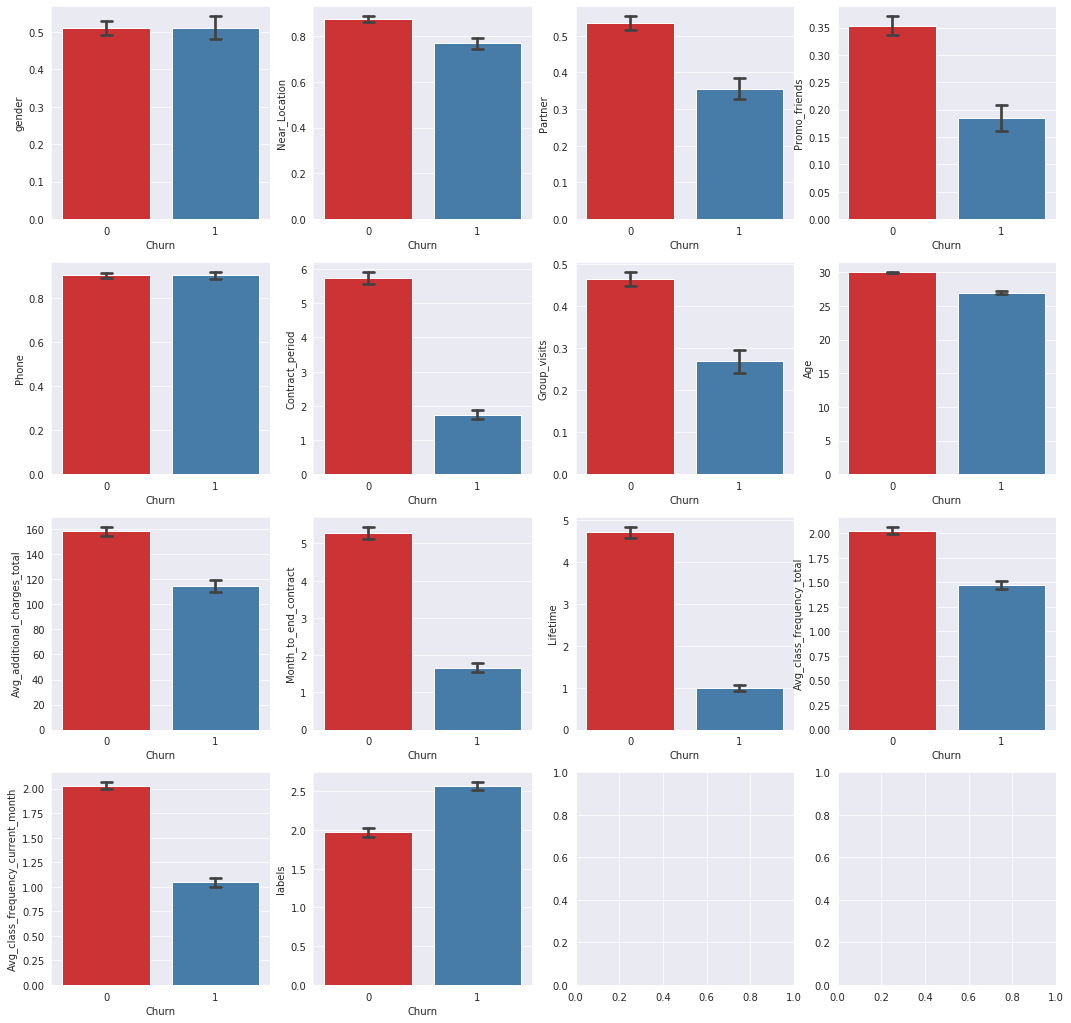

In [39]:
fig, axs = plt.subplots(4, 4, figsize = (18, 18))
sns.set_style("darkgrid")
x = 0
y = 0
for sign in data.columns.drop('Churn'):
    if y < 3:
        sns.barplot(x = "Churn", y = sign, data = data, palette='Set1', ax=axs[x, y])
        y += 1
    else:
        sns.barplot(x = "Churn", y = sign, data = data, palette='Set1', ax=axs[x, y])
        y = 0
        x += 1
        
        
plt.show()

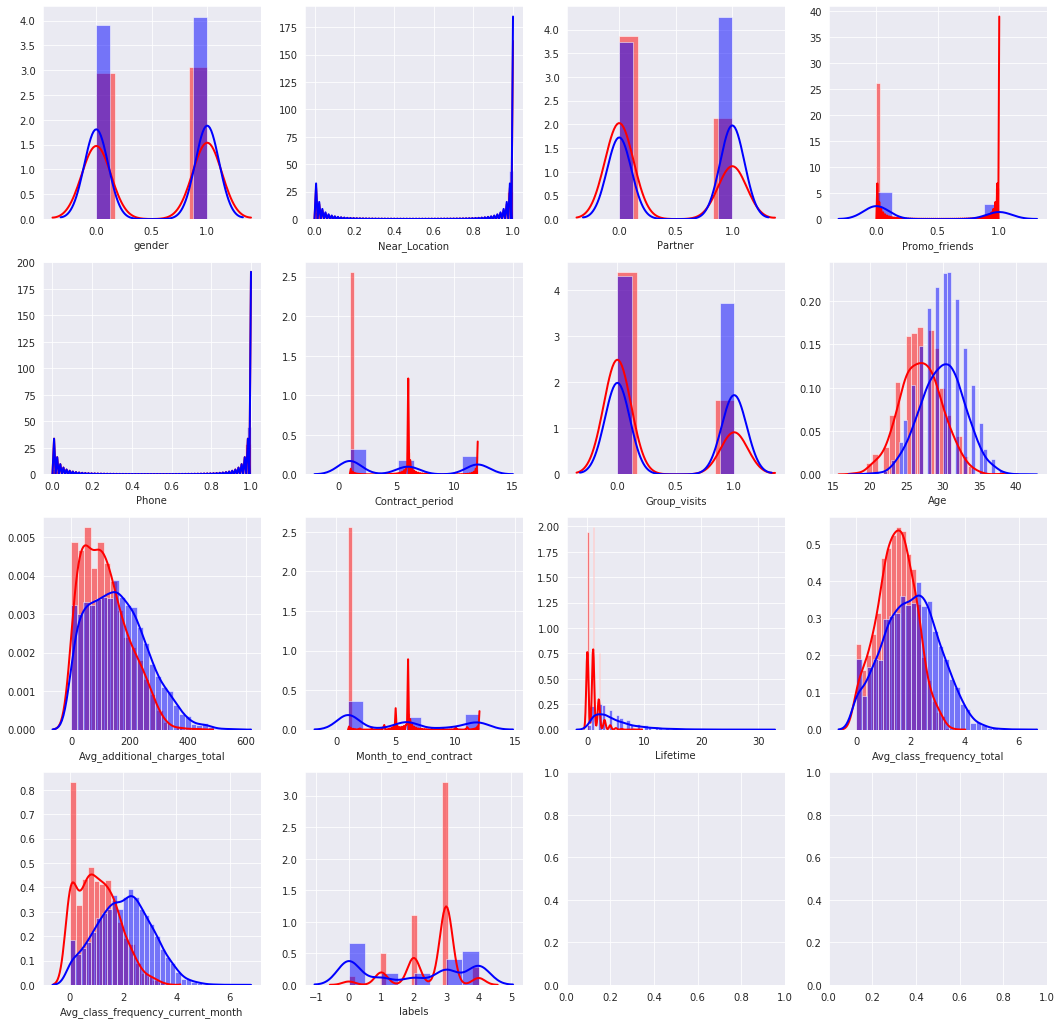

In [58]:
fig, axs = plt.subplots(4, 4, figsize = (18, 18))
x = 0
y = 0
for sign in data.columns.drop('Churn'):
    if y < 3:
        sns.distplot(data[data['Churn'] == 1][sign], color="r", ax=axs[x, y], hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
        sns.distplot(data[data['Churn'] == 0][sign], color="b", ax=axs[x, y], hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
        y += 1
    else:
        sns.distplot(data[data['Churn'] == 1][sign], color="r", ax=axs[x, y], hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
        sns.distplot(data[data['Churn'] == 0][sign], color="b", ax=axs[x, y], hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
        y = 0
        x += 1
plt.show()

Как видно из 1 и 5 графиков, ни возраст, ни наличие телефонного ноемера в анкете никак не сказываются на решении уйти или остаться в сети фитнес-центров. Значения практически одинаковы, а значит, наша модель врядли должна придавать большой вес этим параметрам.

Наибольшую разницу, а значит, скорее всего, и наибольшее влияние, мы видим у таких параметров, как:
- Средняя длительность контракта - у покинувших, она гораздо меньше. Видимо, люди берут пробный абонемент на короткий срок, чтобы понять, нравится им или нет.
- Месяцев до конца контракта - в среднем, до конца абонемента у "оттока" 1.5 месяца, в то время как у остающихся больше 5 месяцев.
- Время с момента первого обращения в фитнес-центр (в месяцах) - получается, чаще всего уходят новые клиенты, которым, видимо, что-то не понравилось

Но не будем гадать, посмотрим на табицу корреляции и узнаем, как сильно влияют те или иные параметры на вероятность оттока, а может и найдём удивительно сильно зависимые между собой параметры:

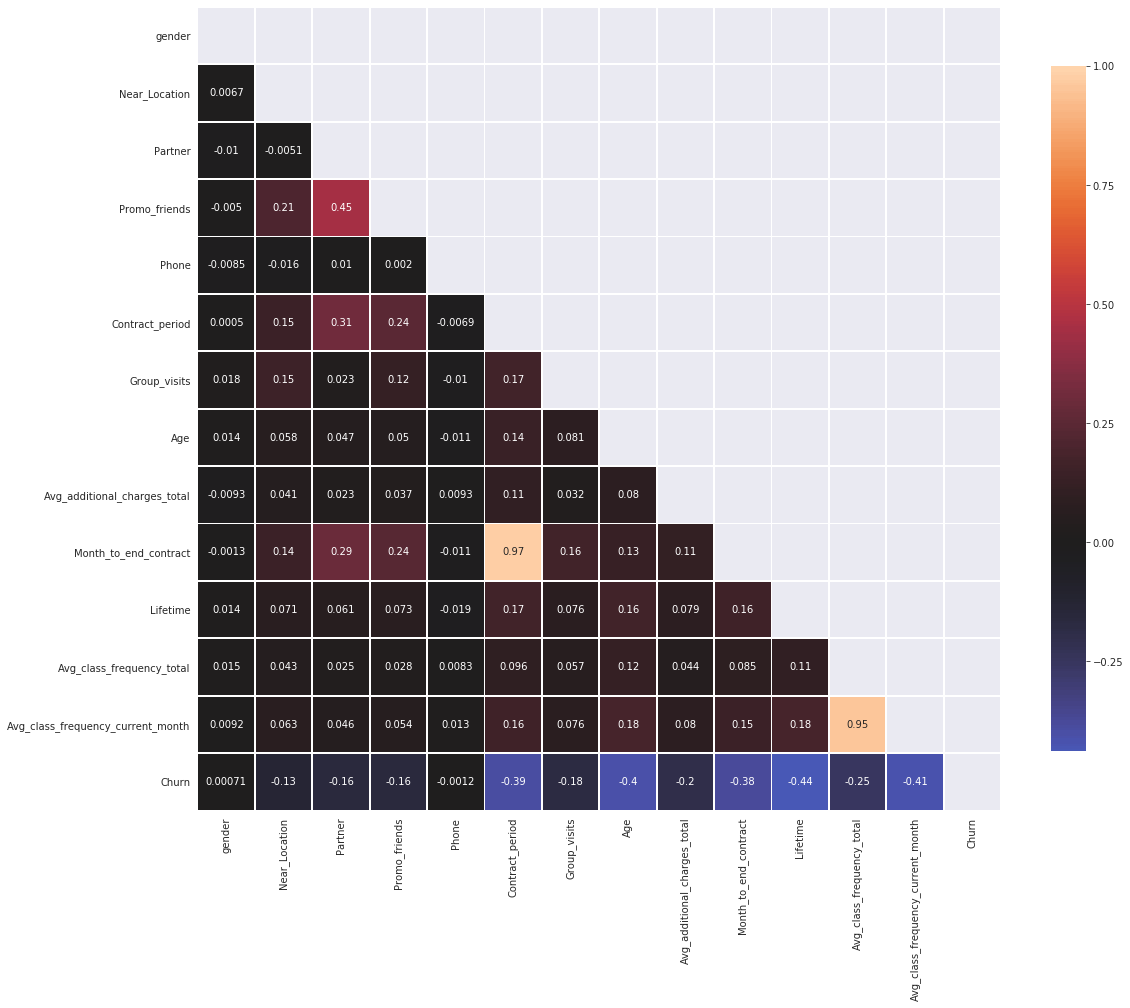

In [9]:
fig, plt.subplots(figsize = (18, 18))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
sns.heatmap(data.corr(),mask = mask, center = 0, square = True, annot = True, linewidths=.75, cbar_kws={"shrink": .7})
plt.show()

Как видно, в общем, признаки между собой коррелируют не сильно, но есть несколько исключений:
- "Общая блительность контракта" и "месяцев до конца контракта" имеют практически 100%ую зависимость. Это связано, с тем, что, во-первых, очень много одномесячных абонементов в базе, во вторых, среднее значение этих показательней очень близко, что говорит, о том, что база содержит данные о пользователях, которые толко недавно начали пользоваться данным контрактом.
- "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц" имеют так же блюзкую к единице корреляцию т.к., видимо, кол-во посещений за предыдущий месяц практически не отличается от среднего показателя клиента.
- "Partner" и "Promo_friends" имеют не высокий показатель корреляции 0.45, но относительно остальных, он выделяется. Это может говорить нам о том, что, например, коллеги, получающие скидку в нашу сеть, склонны ходить вместе.

Что касается влияния на наш ключевой показатель - "факт оттока в текущем месяце", то:
- Пол клиента не оказывает никакого влияния, наличие или отсутствие номера телефона имеет схожее влияние
- Все остальные показатели влияют на него обратнопропорцианально, т.е., например, чем более долгосрочный контракт преобретен, тем меньше вероятность оттока, или, чем выше активность клиента в последний месяц, или в целом, тем так же ниже вероятность оттока. Получается, чем выше активность клиента в каждом из признаков, тем меньше вероятность, что он нас покинет.



## Построение модели прогнозирования оттока клиентов

Разделим данные, на обучающие и валидационные выборки и стандартизируем их, т.к. не все параметры в нашей базе имеют бинарный формат:

In [10]:
X = data.drop('Churn', axis = 1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Список обучающих моделей, которые мы планируем применить и функция, обучающая модель и отображающая показатели точности модели по трём метрикам:

In [11]:
models = [
    LogisticRegression(),
    RandomForestClassifier(random_state = 0),
]

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred))) 

Запускаем цикл для всех моделей, которые мы хотим применить к данным:

In [12]:
for model in models:
    print(model)
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.78


Как видим, по всем метрикам для обеих моделей показатели довольно высокие, но модель логической регрессии превзошла "Случайный лес" по всем метрикам.

В целом, наша модель предсказывает уйдёт или не уйдёт в следующем месяце клиент с точностью 92%, однако, в нашем случае для нас самый важный показатель - Recall, т.к. нам нужно выявить весь потенциальный отток, а данный показатель обеих наших моделей самый низкий - это из плохого.

## Кластеризация клиентов

Произведем стандартизацию, а затем построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму:

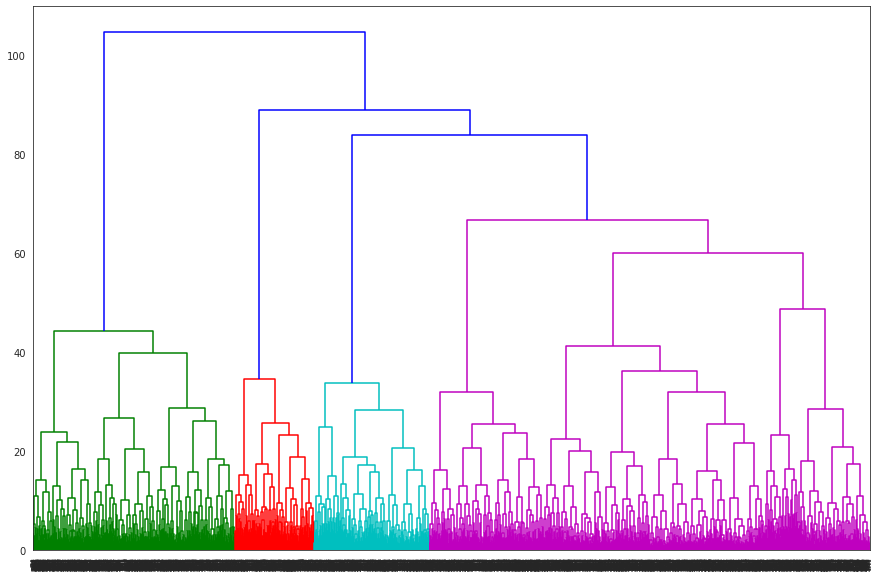

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На мой взгляд, здесь присутствует 6 кластеров примерно одного рарзмера. 4, как предлагает нам дендрограмма, я бы всё же не выделил, так как последний кластер объединил половину всех клиентов.

Берем среднее кол-во кластеров - 5 (как требует условие) и обучаем нашу модель, а затем передаём значения класера каждому из клиентов:

In [14]:
km = KMeans(n_clusters = 5, random_state= 0)
labels = km.fit_predict(X_sc)

data['labels'] = labels

data.groupby('labels').agg({'mean'}).reset_index().drop('labels', axis = 1)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Выведем средние значения общие, для сравнения:

In [15]:
data.drop('labels', axis = 1).mean()

gender                                 0.510250
Near_Location                          0.845250
Partner                                0.486750
Promo_friends                          0.308500
Phone                                  0.903500
Contract_period                        4.681250
Group_visits                           0.412250
Age                                   29.184250
Avg_additional_charges_total         146.943728
Month_to_end_contract                  4.322750
Lifetime                               3.724750
Avg_class_frequency_total              1.879020
Avg_class_frequency_current_month      1.767052
Churn                                  0.265250
dtype: float64

Как мы видим из средних значений, модель кластеризации объеденила наших клиентов так:
- **Первый кластер:** Клиенты с самыми долгими контрактами, но, так как между этимим параметрами высокая степень корреляции, то среди них и самый высокий процент контрактов с партнерскими скидками и пришедших за другом, а так же большое число клиентов, которым недалеко добираться от дома/работы.
- **Второй кластер:** объеденил практически всех клиентов, не указавших номер телефона. Как я писал ранее, этот показатель не влияет на отток, поэтому и кластер оказался во всех остальных параметрах практически идентичным средним общим значениям.
- **Третий кластер:** Сгруппировал в себе клиентов, которые пришли к нам не по причине близости от работы/дома. Спортсмены этого кластера имеют меньшие по длительности контракты, чем в среднем, а так же чуть большее снижение активности в последний месяц перед уходом.
- **Четвертый кластер:** Включил в себя самых "спортивных" спортсменов с самыми низкими показателями посещений в неделю. Средняя длительность контракта у них самая низкая среди всех кластеров, но, при этом, все 100% этой группы - ходят в наши фитнес-центры, которые удобно расположены для них. Так же из того факта, что они впервые контактировали с нашей сетью наименьший период времени назад, предположу, что это клиенты, которые преобрели краткосрочные абонементы не из-за большого желания заниматься спортом, а из-за приятных скидок и факторов, которые не позволили им устоять перед покупкой абонемента.
- **Пятый кластер:** В последний кластер объединились люди с самым высоким показателем кол-ва средний посещений в неделю. Интересный факт, что в последний месяц перед оттоком, их интенсивность тренировок практически не падает. Думаю, если они и уходят, но не по причине разочарования в спорте.

Посмотрим на диаграммы сравнения кластеров по признакам, может узнаем что-то новое:

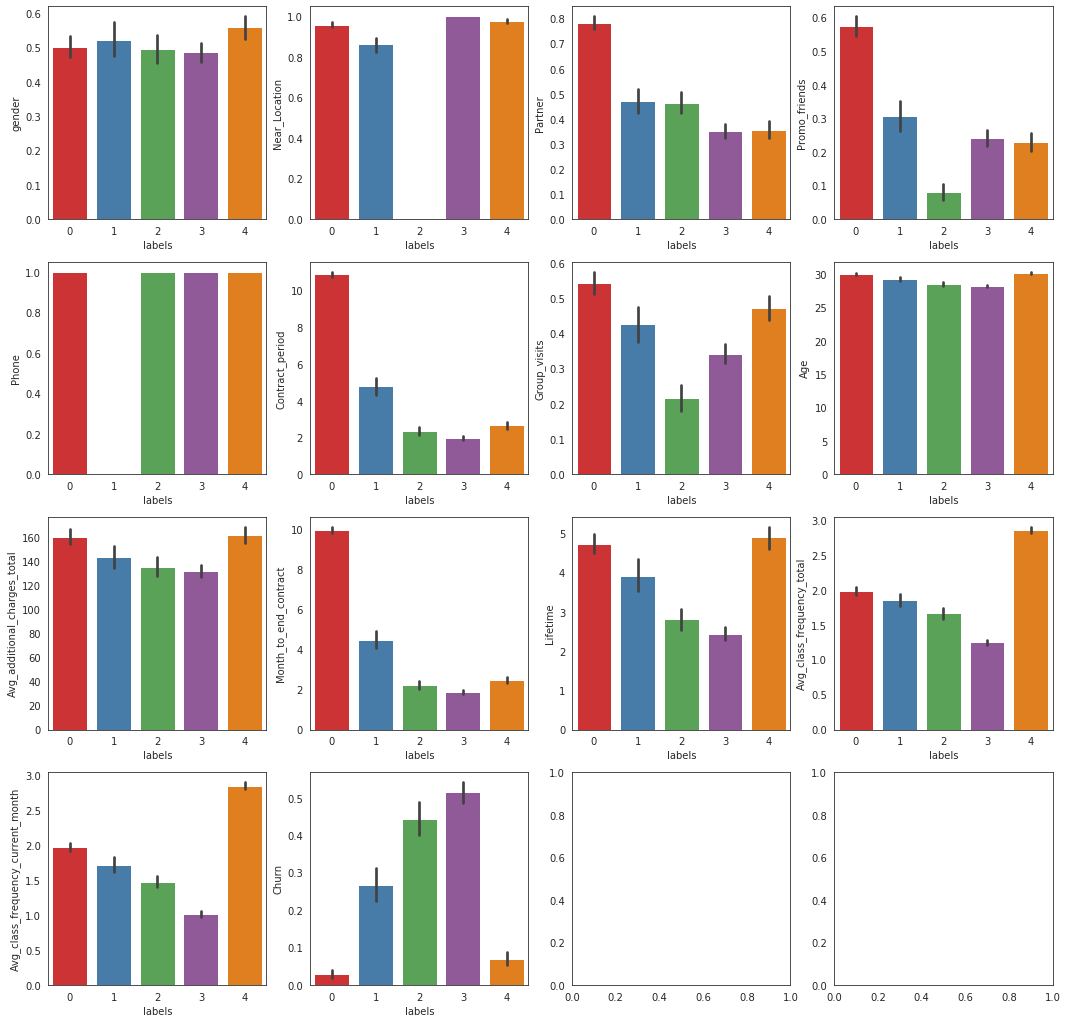

In [16]:
fig, axs = plt.subplots(4, 4, figsize = (18, 18))
sns.set_style("darkgrid")
x = 0
y = 0
for sign in data.columns.drop('labels'):
    if y < 3:
        sns.barplot(x = "labels", y = sign, data = data, palette='Set1', ax=axs[x, y])
        y += 1
    else:
        sns.barplot(x = "labels", y = sign, data = data, palette='Set1', ax=axs[x, y])
        y = 0
        x += 1
        
        
plt.show()

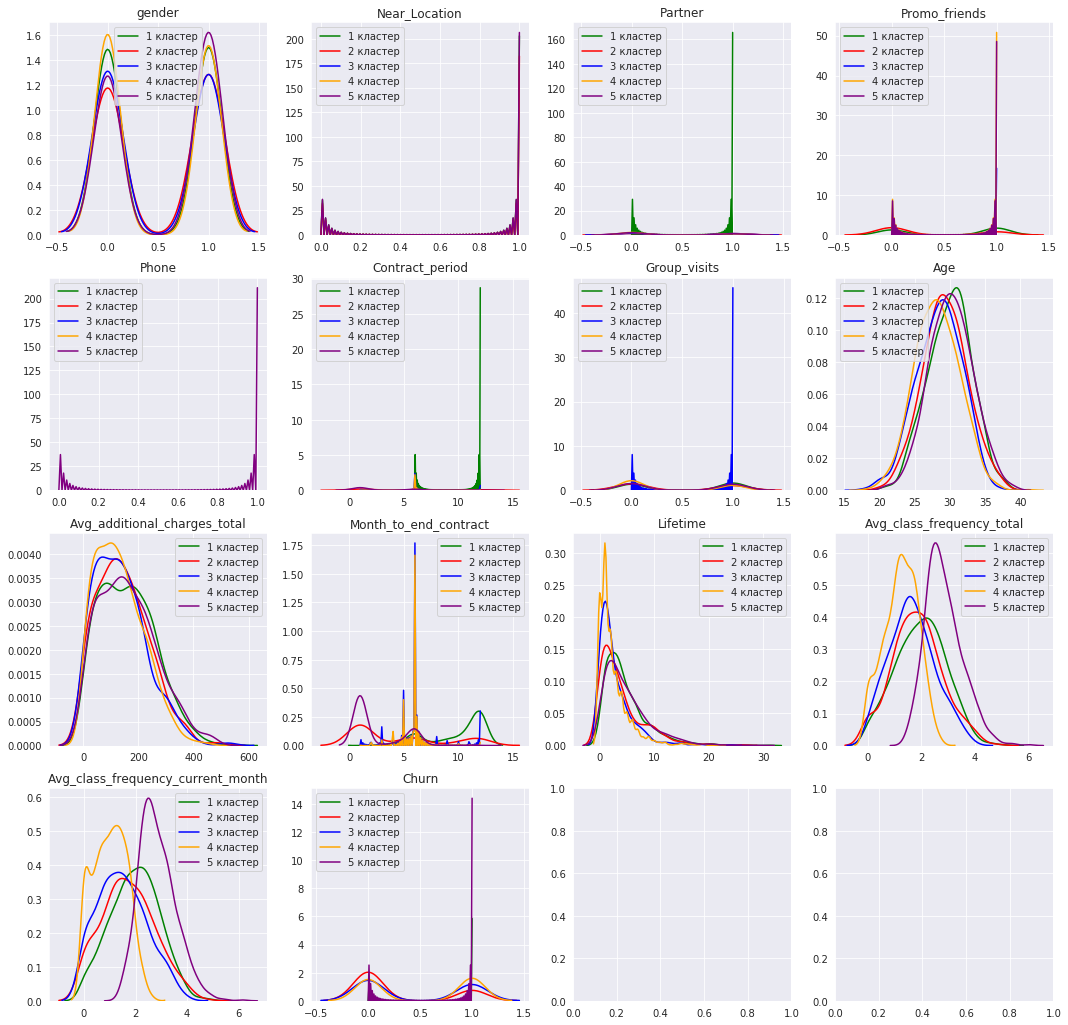

In [80]:
colors = ['g', 'r', 'b', 'orange', 'purple']

fig, axs = plt.subplots(4, 4, figsize = (18, 18))
x = 0
y = 0
for sign in data.columns.drop('labels'):
    if y < 3:
        for i in range(0, 5):
            sns.kdeplot(data[data['labels'] == i][sign], color=colors[i], ax=axs[x, y], label = '{} кластер'.format(i+1))
        axs[x, y].set(title = sign)
        y += 1
    else:
        for i in range(0, 5):
            sns.kdeplot(data[data['labels'] == i][sign], color=colors[i], ax=axs[x, y], label = '{} кластер'.format(i+1))
        axs[x, y].set(title = sign)
        y = 0
        x += 1
plt.show()

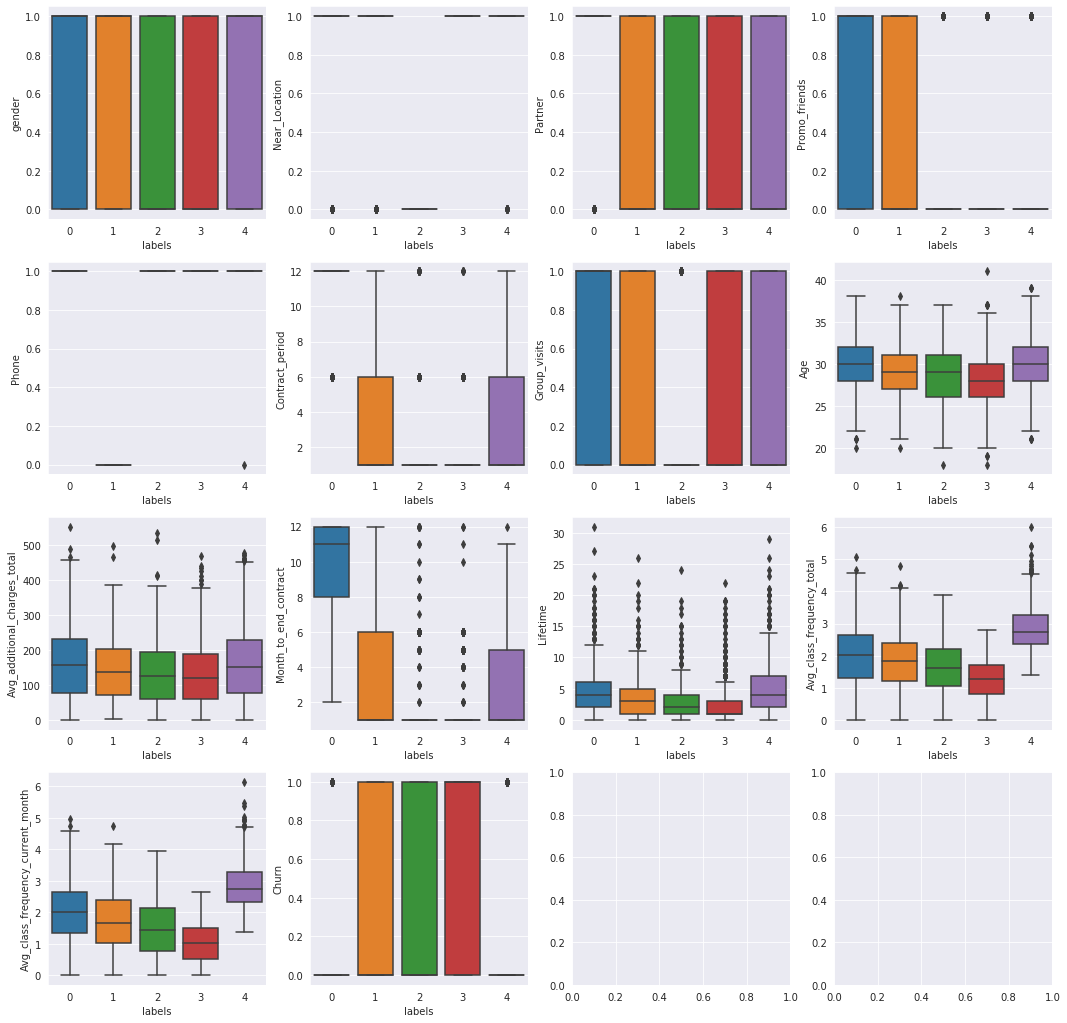

In [88]:
fig, axs = plt.subplots(4, 4, figsize = (18, 18))
x = 0
y = 0
for sign in data.columns.drop('labels'):
    if y < 3:
        sns.boxplot(x ='labels', y = sign, data = data, ax=axs[x, y])
        y += 1
    else:
        sns.boxplot(x ='labels', y = sign, data = data, ax=axs[x, y])
        y = 0
        x += 1
plt.show()

Как мы видим, я оказался прав в вопросе выбора признака, по которому сгруппированы данные каждого кластера, т.к. выбранные мной показатели распределены очень близко к среднему значению.

In [17]:
data.groupby('labels').agg({'Churn':'mean'}).sort_values(by = 'Churn', ascending = True)

,Churn
labels,
0,0.027695
4,0.068100
1,0.267532
2,0.443564
3,0.514263


Ну а теперь самое интересное, какие же кластеры склонны к оттоку, а какие наши лчшие клиенты, которые нас никогда не покинут?

**Самые склонные к оттоку:**
- клиенты 4 кластера - не особо спортсмены, купившие абонемент по скидке партнерской, или вообще получившие его в подарок (который был куплен, в свою очередь, из-за скидки).
- клиенты 3 кластера - видимо, близость к работе/дому - один из ключевых факторов для успещных занятий в фитнес-центре.

**Наши любимые клиенты:**
- клиенты 1 кластера - практически нулевой отток. Еще бы, только выложил кругленькую сумму за годовой абонимент и тут же уходить! Нет уж, дудки, раз уплочено, значит будем заниматься.
- клиенты 5 кластера - те, кто реально приходит заниматься спортом, поэтому просто так их из тренажёрного зала не выгнать.

**P.S.** Ну и 2 кластер, который объеденили по причине неуказанного номера телефона, имеет абсолютно средние показатели по "больнице".

## Выводы и рекомендации по работе с клиентами

Я бы, всё же, выделил 4 группы клиентов: 
- <span style="color:Green">Клиенты с долгосрочными контрактами</span>
- <span style="color:Green">Клиенты, часто и регулярно посещающие фитнес-фентр</span>
- <span style="color:Red">Новые клиенты, приобретающие краткосрочные контракты </span>
- <span style="color:Red">Клиенты, далеко живущие/работающие от фитнес-центра</span>

На мой взгляд, наши стратегии должны быть направлены на стимуляцию поведения, подобоного кластерам с низким оттоком, либо предоставление бонусов, компенсирующих низкие значения отстающих показателей с высоким коэффициентом влияния.

Например:
- Изменение ценовой политики, стимулирующей клиентов покупать более долгосрочные контракты. 
- Акции, позволяющие втянуться в тренировочный процесс, чтобы клиенты увеличивали среднее кол-во занятий в неделю. Такой акцией может быть, например, большая скидка на занятия с личным тренером в первые N тренировок/недель.
- Для клиентов, далеко живущих/работающих от фитнес-центров можно разработать систему акций/бонусов совместно с, например, сервисами такси, для клиентов без автомобилей, или с авто-мойками неподалеку от центра (если имеются) для клиентов на своём авто.
- Один из ключевых показателей - Lifetime, это значит, что в целом наши клиенты со временем не разочаровываются в сети, а основной отток идёт у новых клиентов. Возможно, стоит организовать акции для клиентов, заключающих контракт с нами впервые, чтобы улучшить их начальное впечатление о нас. Так как такие клиенты чаще всего покупаю одномесячные абоменементы и уходят, не попробовав все наши услуги, то, стоит им предложить, во-первых, более приятную цену на 3 мес, вместо 1, а так же включенный в него пакет платных услуг и/или скидку на другие услуги фитнес-центра. Таким образом, те, кого мы в любом случае не могли удержать, уйдут, но заплатят не за 1 мес контракт, а за 3 мес., а те, кого мы могли удержать, ознакомятся с более широким спектром наших услуг и, нарастят показатель Lifetime и решат остаться.